In [1]:
from collections import defaultdict
from pymongo import MongoClient
import matplotlib

%matplotlib inline


client = MongoClient()
db = client["senators"]
coll = db["raw_xml"]

In [2]:
from sklearn.feature_selection import SelectKBest
from lxml import etree
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from sklearn.feature_selection import chi2

def partisan_bills(votes):
    senator_names = [ name for name in votes.keys() if ("(R-" in name ) or ("(D-" in name) ]
    senators = [ votes[name] for name in senator_names ]
    truth = map(lambda name: int("(R-" in name), senator_names)
    
    bill_vectorizer = DictVectorizer()
    features = bill_vectorizer.fit_transform(senators)
    
    kbest = SelectKBest(k=25).fit(features, truth)
    top25 = np.argsort(kbest.pvalues_)[:25]
    bills = bill_vectorizer.get_feature_names()

    for cong, sess, vote_num in map(lambda i: bills[i], top25):
        raw_xml = coll.find({"congress": cong, "session": sess, "vote_num": vote_num},{"raw": 1})[0]['raw']
        root = etree.XML(raw_xml.encode('utf-8'))
        print "{} Congress, Session {}, Vote Number {}".format(cong, sess, vote_num)
        print root.xpath("//vote_question_text")[0].text
        print root.xpath("//vote_document_text")[0].text
        print
    

In [35]:
obama_votes = defaultdict(dict)

for cong in range(111,115):
    for roll_call in coll.find({"congress": cong},{"raw":0}):
        for member in roll_call["votes"]:
            obama_votes[member["name"]][(cong, roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

In [38]:
partisan_bills(obama_votes)

114 Congress, Session 1, Vote Number 00119
On the Amendment S.Amdt. 951 to S.Con.Res. 11 (No short title on file)
To establish and fund a new Federal-State partnership to expand access to high-quality preschool programs for children from low- and moderate-income families, offset with revenue from closing loopholes.

114 Congress, Session 1, Vote Number 00117
On the Amendment S.Amdt. 842 to S.Con.Res. 11 (No short title on file)
To establish a deficit-neutral reserve fund relating to consumer fiancial protection.

114 Congress, Session 1, Vote Number 00111
On the Amendment S.Amdt. 1072 to S.Con.Res. 11 (No short title on file)
To provide additional resources to reject the Senate Republicans' proposed $435 billion in cuts to Medicare.

114 Congress, Session 1, Vote Number 00110
On the Amendment S.Amdt. 966 to S.Con.Res. 11 (No short title on file)
To establish a deficit-neutral reserve fund relating to offsetting the costs of operations against the Islamic State.

114 Congress, Session 1

In [39]:
bush_votes = defaultdict(dict)

for cong in range(107,111):
    for roll_call in coll.find({"congress": cong},{"raw":0}):
        for member in roll_call["votes"]:
            bush_votes[member["name"]][(cong,roll_call["session"],roll_call["vote_num"])] = member["vote_score"]

In [40]:
partisan_bills(bush_votes)

109 Congress, Session 1, Vote Number 00078
On the Amendment S.Amdt. 211 to S.Con.Res. 18 (No short title on file)
To restore funding for tribal programs and provide necessary additional funding based on recommendations from Indian country

109 Congress, Session 1, Vote Number 00047
On the Amendment S.Amdt. 144 to S.Con.Res. 18 (No short title on file)
To ensure that 75-year solvency has been restored to Social Security before Congress considers new deficit-financed legislation that would increase mandatory spending or cut taxes.

109 Congress, Session 1, Vote Number 00070
On the Amendment S.Amdt. 239 to S.Con.Res. 18 (No short title on file)
Relative to funding to the Office of Community Oriented Policing Services.

109 Congress, Session 2, Vote Number 00035
On the Amendment S.Amdt. 2932 to S. 2349 (527 Reform Act of 2006)
To provide additional transparency in the legislative process.

109 Congress, Session 1, Vote Number 00297
On the Motion (Motion To Waive CBA Re: Lautenberg Amdt. No

In [23]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
import random

def graph_bills(bills, model="agglomerative", k=3):
    dict_vectorizer = DictVectorizer()
    features = dict_vectorizer.fit_transform(bills)

    if model == "agglomerative":
        labels = AgglomerativeClustering(n_clusters=k).fit_predict(features.toarray())
    elif model == "kmeans":
        labels = KMeans(n_clusters=k).fit_predict(features)
    return labels
        
    matplotlib.rcParams['figure.figsize'] = (15.0,12.0)

    mds = MDS()
    coords = mds.fit_transform(features.toarray())
    plot = plt.scatter(coords[:,0], coords[:,1], c=labels, s=100)
    plt.axis("off")

In [4]:
obama_bills = defaultdict(dict)
bill_names = dict()

for cong in range(111,115):
    for roll_call in coll.find({"congress": cong},{"raw":0}):
        for member in roll_call["votes"]:
            obama_bills[(cong, roll_call["session"],roll_call["vote_num"])][member["name"]] = member["vote_score"]

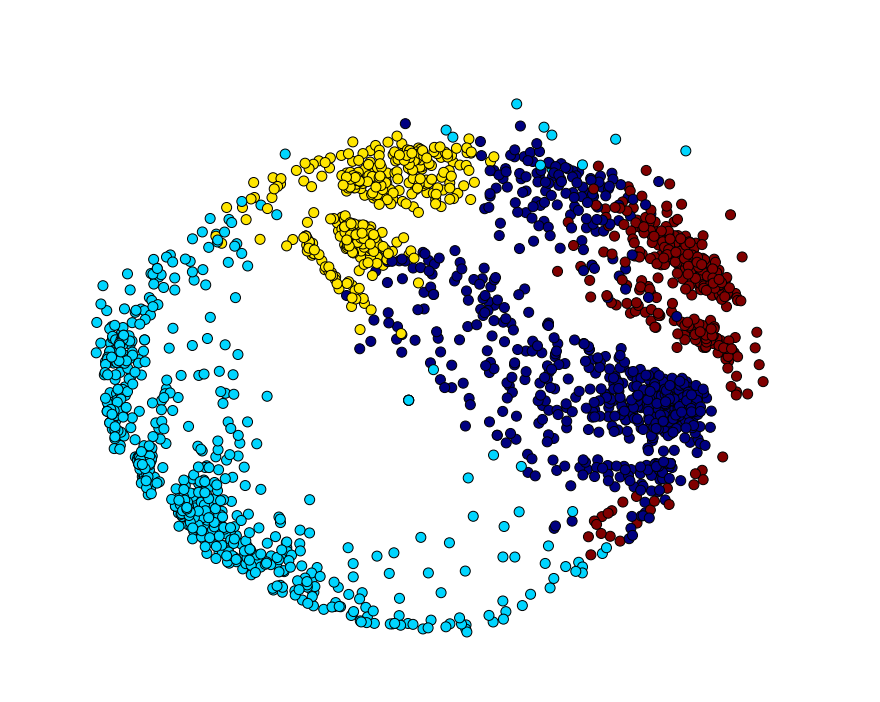

In [25]:
graph_bills([ vote for (cong,sess,vote_num),vote in obama_bills.items()], "agglomerative", 4)

In [31]:
senator_vectorizer = DictVectorizer()
bill_ids = obama_bills.keys()
votes = [ obama_bills[bill_id] for bill_id in bill_ids ]
features = senator_vectorizer.fit_transform(votes)

In [27]:
mds = MDS()
coords = mds.fit_transform(features.toarray())

In [75]:
labels = AgglomerativeClustering(n_clusters=3).fit_predict(features.toarray())

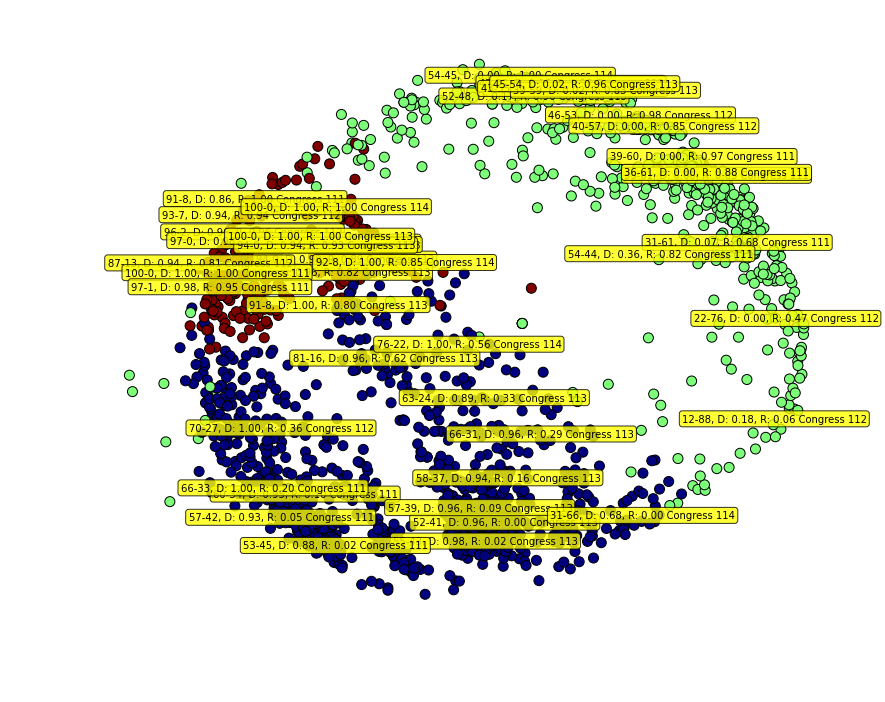

In [78]:
plot = plt.scatter(coords[:,0], coords[:,1], c=labels, s=100)
plt.axis("off")

senators = senator_vectorizer.get_feature_names()

def percent(fun, lst):
    matching = sum([ int(fun(x)) for x in lst])
    return matching / float(len(lst))

def invert_cluster_labels(labels):
    """
    Takes in an array-like of shape [n_samples] 
    and returns a dict mapping each label to the list of samples in that cluster
    """
    result = defaultdict(list)
    for sample, label in enumerate(labels):
        result[label].append(sample)
    return result

for cluster in invert_cluster_labels(labels).values():
    random_bills = random.sample([(coords[i], bill_ids[i]) for i in cluster], 15)
    for xy, (cong, sess, vote_num) in random_bills:
        raw_xml = coll.find({"congress": cong, "session": sess, "vote_num": vote_num},{"raw": 1})[0]['raw']
        root = etree.XML(raw_xml.encode('utf-8'))

        bill = obama_bills[(cong, sess, vote_num)]

        yeas = root.xpath("count/yeas")[0].text
        nays = root.xpath("count/nays")[0].text
        vote_result = root.xpath("vote_result_text")[0].text

        dems = filter(lambda (name, vote_score): "(D-" in name, bill.items())
        gop  = filter(lambda (name, vote_score): "(R-" in name, bill.items())

        percent_dem_yeas = percent(lambda (name, vote_score): vote_score > 0, dems)
        percent_gop_yeas = percent(lambda (name, vote_score): vote_score > 0, gop)

        annotation = "{0}-{1}, D: {2:.2f}, R: {3:.2f} Congress {4}".format(yeas, nays, percent_dem_yeas, percent_gop_yeas, cong)

        plt.annotate(annotation, xy = xy, xytext = (1, 1),
            textcoords = 'offset points', ha = 'center', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.3', fc="yellow",alpha = .8)
        )
plt.show()

In [93]:
def graph_votes_by_party(cong_range):
    x_coords = []
    y_coords = []
    passed = []

    for cong in cong_range:
        for roll_call in coll.find({"congress": cong}):
            raw_xml = roll_call['raw']
            root = etree.XML(raw_xml.encode('utf-8'))

            yeas = root.xpath("count/yeas")[0].text
            nays = root.xpath("count/nays")[0].text
            vote_result = root.xpath("vote_result_text")[0].text

            dems = filter(lambda rec: "(D-" in rec["name"], roll_call["votes"])
            gop  = filter(lambda rec: "(R-" in rec["name"], roll_call["votes"])

            passed.append(int("Rejected" in vote_result))
            percent_dem_yeas = percent(lambda rec: rec["vote_score"] > 0, dems)
            percent_gop_yeas = percent(lambda rec: rec["vote_score"] > 0, gop)
            x_coords.append(percent_dem_yeas)
            y_coords.append(percent_gop_yeas)

    plot = plt.scatter(x_coords, y_coords, c=passed, s=100)
    plt.xlabel("Dem")
    plt.ylabel("GOP")

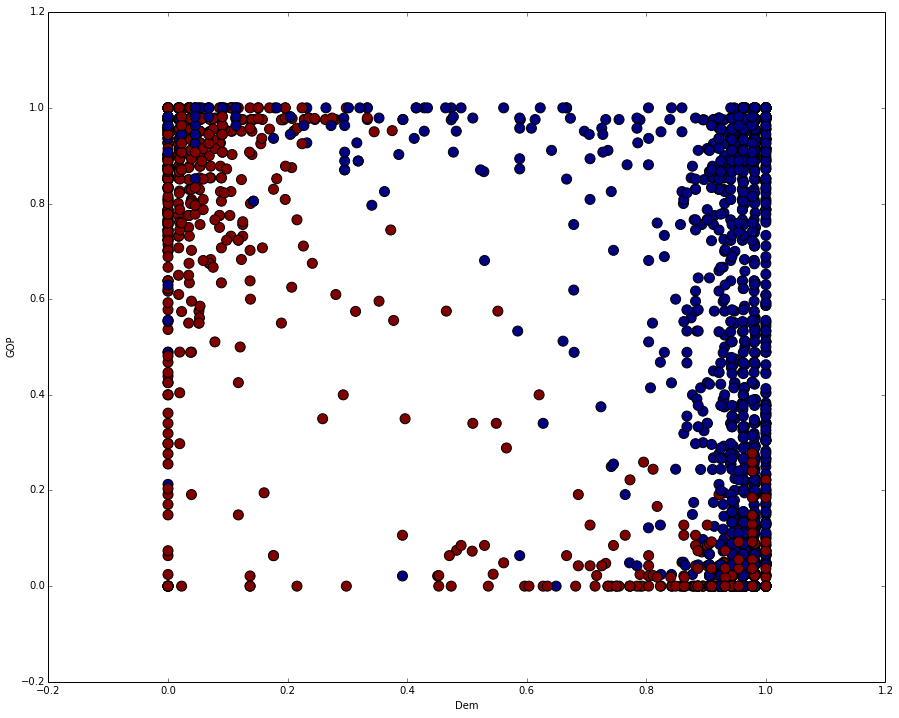

In [94]:
graph_votes_by_party(range(111,115))

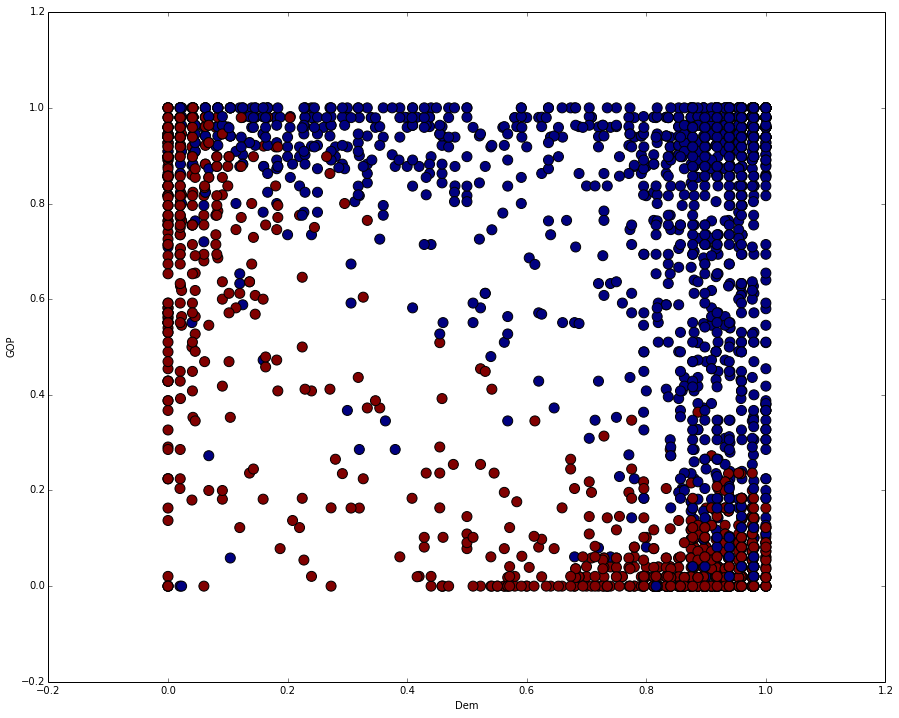

In [95]:
graph_votes_by_party(range(107,111))

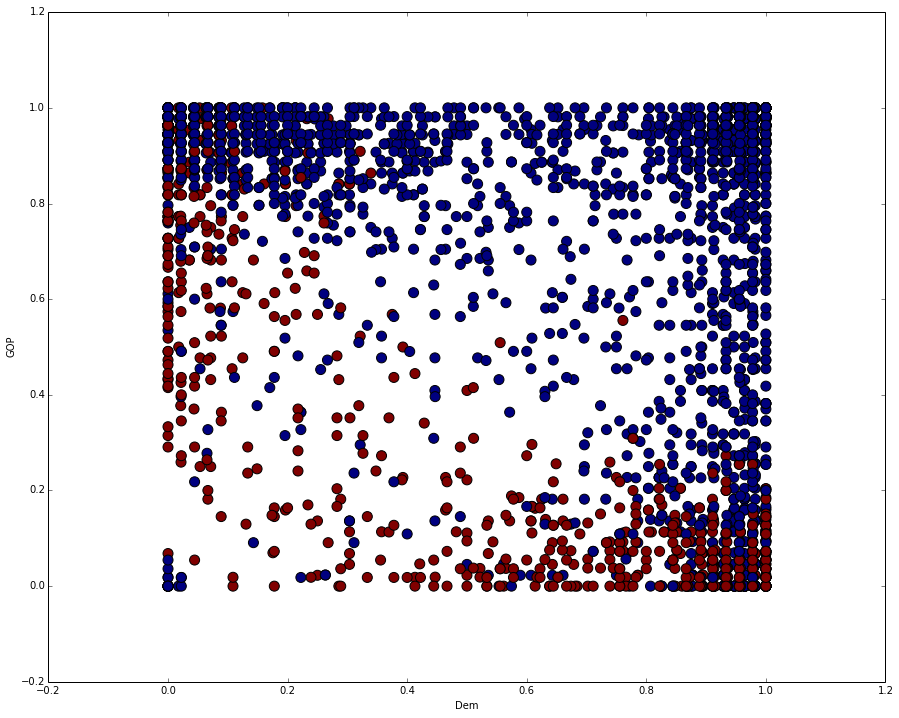

In [96]:
graph_votes_by_party(range(103,107))